In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
# from tqdm.notebook import tqdm

In [ ]:
# Create the CartPole Environment
env = gym.make('CartPole-v1')

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

In [ ]:


# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU()
        )

        # Actor head
        self.actor_head = nn.Sequential(
            nn.Linear(64, action_size),
            nn.Softmax(dim=-1)
        )

        # Critic head
        self.critic_head = nn.Linear(64, 1)

    def forward(self, state):
        # Forward pass through shared layers
        x = self.shared_layers(state)

        # Forward pass through actor head
        action_probs = self.actor_head(x)

        # Forward pass through critic head
        state_value = self.critic_head(x)

        return action_probs, state_value

# Example initialization and usage
# actor_critic = ActorCritic(state_size, action_size)
# action_probs, state_value = actor_critic(state_tensor)

In [ ]:
actor_critic = ActorCritic(state_size, action_size)

In [ ]:
# If you need separate optimizers for actor and critic with different learning rates or parameters
# We need to specify parameter groups if parameters are not shared
actor_params = list(actor_critic.shared_layers.parameters()) + list(actor_critic.actor_head.parameters())
critic_params = list(actor_critic.shared_layers.parameters()) + list(actor_critic.critic_head.parameters())

actor_optimizer = optim.Adam(actor_params, lr=0.001)
critic_optimizer = optim.Adam(critic_params, lr=0.001)

In [ ]:
env.reset()[0]

array([-0.0219407 , -0.01116521, -0.01874262, -0.01205127], dtype=float32)

In [ ]:
# import torch

# Assuming the ActorCritic class and environment 'env' are properly defined
# Create an instance of the ActorCritic network
actor_critic = ActorCritic(state_size, action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training parameters
num_episodes = 2000
gamma = 0.99

#track scores
episode_rewards = []

# Main training loop
for episode in range(num_episodes):
    state = env.reset()[0]
    state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    episode_reward = 0

    for t in range(1, 1000):  # Limit the number of time steps
        # No need to use GradientTape; PyTorch handles gradients automatically
        # Choose an action using the actor
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Take the chosen action and observe the next state and reward
        next_state, reward,done, truncated, info = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Compute the advantage
        # _, state_value = actor_critic(state)
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value * (1 - int(done)) - state_value

        # Compute actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)

        # Combine losses for joint update
        total_loss = actor_loss + critic_loss

        # Update actor and critic
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward


        if done or truncated:
            break
    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}")

env.close()

/Users/kai/miniconda3/envs/thesis/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 15.0
Episode 10, Reward: 16.0
Episode 20, Reward: 17.0
Episode 30, Reward: 10.0
Episode 40, Reward: 25.0
Episode 50, Reward: 12.0
Episode 60, Reward: 15.0
Episode 70, Reward: 27.0
Episode 80, Reward: 34.0
Episode 90, Reward: 131.0
Episode 100, Reward: 22.0
Episode 110, Reward: 18.0
Episode 120, Reward: 32.0
Episode 130, Reward: 30.0
Episode 140, Reward: 18.0
Episode 150, Reward: 86.0
Episode 160, Reward: 54.0
Episode 170, Reward: 73.0
Episode 180, Reward: 161.0
Episode 190, Reward: 57.0
Episode 200, Reward: 203.0
Episode 210, Reward: 16.0
Episode 220, Reward: 187.0
Episode 230, Reward: 100.0
Episode 240, Reward: 23.0
Episode 250, Reward: 146.0
Episode 260, Reward: 156.0
Episode 270, Reward: 64.0
Episode 280, Reward: 43.0
Episode 290, Reward: 79.0
Episode 300, Reward: 70.0
Episode 310, Reward: 95.0
Episode 320, Reward: 167.0
Episode 330, Reward: 123.0
Episode 340, Reward: 124.0
Episode 350, Reward: 189.0
Episode 360, Reward: 161.0
Episode 370, Reward: 114.0
Episode 38

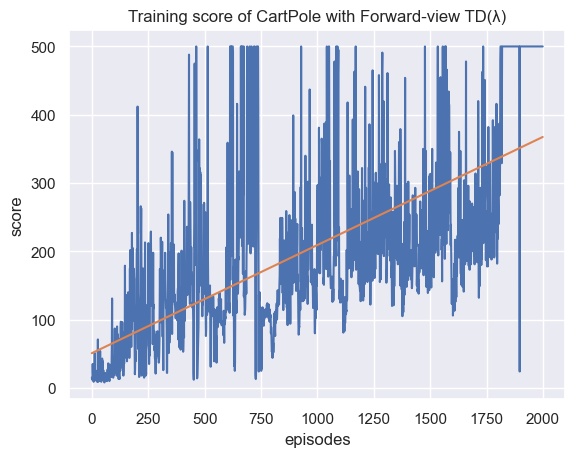

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with Forward-view TD(λ)')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

## Trying Policy:

In [ ]:
done = False
# state = env.reset()[0]
scores = []

for test in range(50):
    state = env.reset()[0]
    state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    done = False
    score = 0
    for step in range(600):
        #env.render()
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Take the chosen action and observe the next state and reward
        next_state, reward,done, truncated, info = env.step(action.item())

        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        score += reward
        state = next_state
    scores.append(score)

In [ ]:
print(np.array(scores).mean())
print(len(scores))

600.0
50


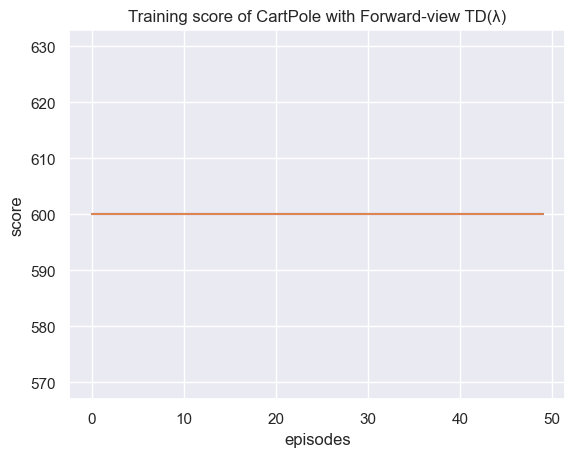

In [ ]:
sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with Forward-view TD(λ)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()